In [1]:
import torch
import triton
import triton.language as tl

DEVICE = torch.device(f'cuda:{torch.cuda.current_device()}')

In [32]:
def test_add_kernel(size, atol=1e-3, rtol=1e-3, device=DEVICE):
    torch.manual_seed(0)
    x = torch.randn(size, device=device, dtype=torch.float32)
    y = torch.randn(size, device=device, dtype=torch.float32)

    z_tri = add(x, y)
    z_ref = x + y

    torch.testing.assert_close(z_tri, z_ref, atol=atol, rtol=rtol)
    print('passed')

In [27]:
def add(x, y):
    output = torch.empty_like(x)

    assert x.device == DEVICE and y.device == DEVICE

    # define a launch grid
    n_elements = output.numel()
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), ) 
    # cdiv(m, n) = (m + (n-1)) // n

    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)

    return output

In [28]:
@triton.jit
def add_kernel(
    x_ptr,
    y_ptr,
    output_ptr,
    n_elements,
    BLOCK_SIZE: tl.constexpr,
):
    pid = tl.program_id(axis=0)

    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements

    x = tl.load(x_ptr + offsets)
    y = tl.load(y_ptr + offsets)

    output = x + y

    tl.store(output_ptr + offsets, output, mask=mask)

In [38]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],
        x_vals=[2**i for i in range(12, 28, 1)],
        x_log=True,
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=['Triton', 'Torch'],
        styles=[('blue', '-'), ('green', '-')],
        ylabel='GB/s',
        plot_name='vector-add-performance',
        args={},
    )
)
def benchmark(size, provider):
    x = torch.randn(size, device=DEVICE, dtype=torch.float32)
    y = torch.randn(size, device=DEVICE, dtype=torch.float32)

    quantiles = [0.5, 0.05, 0.95]

    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y), quantiles=quantiles)

    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)

    return gbps(ms), gbps(max_ms), gbps(min_ms)

In [35]:
test_add_kernel(size=4096)
test_add_kernel(size=4097)
test_add_kernel(size=89922)

passed
passed
passed


vector-add-performance:
           size      Triton       Torch
0        4096.0    0.857143    8.000000
1        8192.0   14.769230   15.999999
2       16384.0   27.428571   27.428571
3       32768.0   54.857142   54.857142
4       65536.0   85.333330   85.333330
5      131072.0  127.999995  127.999995
6      262144.0  153.600004  146.285715
7      524288.0  170.666661  175.542852
8     1048576.0  192.000000  192.000000
9     2097152.0  210.051276  210.051276
10    4194304.0  218.453337  218.453337
11    8388608.0  222.407245  223.164582
12   16777216.0  225.986210  225.986210
13   33554432.0  231.716694  230.896060
14   67108864.0  231.031722  231.269516
15  134217728.0  233.587884  233.535855


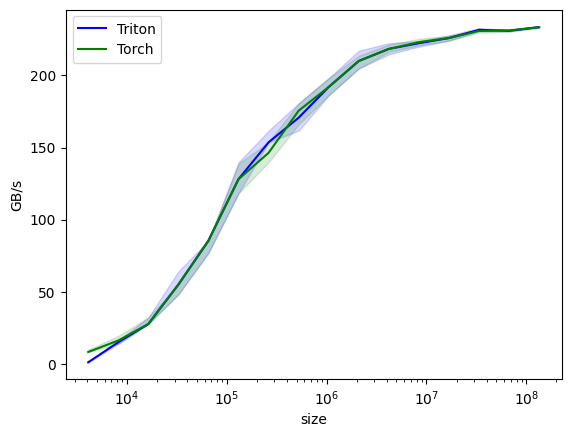

In [39]:
benchmark.run(save_path='.', print_data=True)